In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')

In [2]:
import warnings
warnings.filterwarnings("ignore")
import scanpy.api as sc
from scanpy.neighbors import Neighbors
import scanorama

# Evaluating Alignment Score For Batch Correction

This notebook evaluates an "alignment score" to quantify the effects of batch correction. This notebook uses this metric to measure the performance of the Scanorama algorithm on two batches of Olivier's CAOV3 data with one batch receiving an addition of random gaussian noise.

# Load Data

In [3]:
B1 = sc.read_10x_mtx("./data/Harismendy_data/170206/CAOV3", var_names="gene_symbols")
B2 = sc.read_10x_mtx("./data/Harismendy_data/170315/CAOV3", var_names="gene_symbols")

## Downsample For Performance

In [4]:
def downsample_anndata(ad, n):
    rand_obs = np.random.choice(list(ad.obs.index), size=n, replace=False)
    return ad[rand_obs,:]

In [5]:
CAOV3_B1 = downsample_anndata(B1, 800)
CAOV3_B2 = downsample_anndata(B2, 800)

In [6]:
CAOV3_B1.shape

(800, 33694)

In [7]:
CAOV3_B2.shape

(800, 33694)

In [8]:
"""
# save variables
with open('b1.pckl', 'wb') as f:  
    pickle.dump(CAOV3_B1, f)
with open('b2.pckl', 'wb') as f:  
    pickle.dump(CAOV3_B2, f)

# Getting back the objects:
with open('b1.pckl', 'rb') as f:  
    CAOV3_B1 = pickle.load(f)
"""

"\n# save variables\nwith open('b1.pckl', 'wb') as f:  \n    pickle.dump(CAOV3_B1, f)\nwith open('b2.pckl', 'wb') as f:  \n    pickle.dump(CAOV3_B2, f)\n\n# Getting back the objects:\nwith open('b1.pckl', 'rb') as f:  \n    CAOV3_B1 = pickle.load(f)\n"

# Implement Alignment Score

In [9]:
INPUT_ANNS = [CAOV3_B1, CAOV3_B2]

In [10]:
min_cells = min(list(map(lambda x: x.n_obs, INPUT_ANNS)))
DS_ANNS = list(map(lambda x: downsample_anndata(x, min_cells), INPUT_ANNS))

## Merge Experiments

In [11]:
COMB_ANN = DS_ANNS[0].concatenate(DS_ANNS[1:], index_unique="_")
COMB_ANN.shape

(1600, 33694)

## Find Closest 1% Neighbors For All Cells

In [12]:
n_batch = len(INPUT_ANNS)

In [13]:
n_neighbors = max(int(0.01*min_cells), 10)
n_neighbors

10

In [14]:
sc.pp.neighbors(COMB_ANN, n_neighbors=22, knn=True)

         Falling back to preprocessing with `sc.pp.pca` and default params.


## Calculate Alignment Score

In [15]:
rows, cols = COMB_ANN.uns['neighbors']['distances'].nonzero()

In [16]:
def get_batch(i, adata):
    """
    Returns the batch number of a cell at index i in adata
    """
    return int(adata.obs.index[i].split('_')[1])

In [17]:
neighbor_counts = {}  #{cell_id: #same_batch}

for x, y in zip(rows, cols):
    try:
        neighbor_counts[x]
    except KeyError:
        neighbor_counts[x] = 0
    cell_batch = get_batch(x, COMB_ANN)
    neigh_batch = get_batch(y, COMB_ANN)
    if cell_batch == neigh_batch:
        neighbor_counts[x] += 1

In [18]:
(np.mean(list(neighbor_counts.values()))/n_neighbors)*n_batch

2.2152500000000002

# Summary Implementation Function

This cell defines a single function to run the above analysis given a list of AnnData

In [19]:
def downsample_anndata(ad, n):
    rand_obs = np.random.choice(list(ad.obs.index), size=n, replace=False)
    return ad[rand_obs,:]

def get_batch(i, adata):
    """
    Returns the batch number of a cell at index i in adata
    """
    return int(adata.obs.index[i].split('_')[1])

def score_batch_corr(anns, n_neighbors):
    min_cells = min(list(map(lambda x: x.n_obs, anns)))
    ds_anns = list(map(lambda x: downsample_anndata(x, min_cells), anns))
    comb_ann = ds_anns[0].concatenate(ds_anns[1:], index_unique="_")
    sc.tl.pca(comb_ann)
    sc.pp.neighbors(comb_ann, n_neighbors=n_neighbors, knn=True)
    rows, cols = comb_ann.uns['neighbors']['distances'].nonzero()
    neighbor_counts = {}  #{cell_id: #same_batch}
    for x, y in zip(rows, cols):
        try:
            neighbor_counts[x]
        except KeyError:
            neighbor_counts[x] = 0
        cell_batch = get_batch(x, comb_ann)
        neigh_batch = get_batch(y, comb_ann)
        if cell_batch != neigh_batch:
            neighbor_counts[x] += 1
    sc.pl.pca(comb_ann, color='batch', show=True, save=False)
    return (np.mean(list(neighbor_counts.values()))/n_neighbors)*len(anns)

In [20]:
N_NEIGHBORS = int(0.01*CAOV3_B1.shape[0])
N_NEIGHBORS = 10

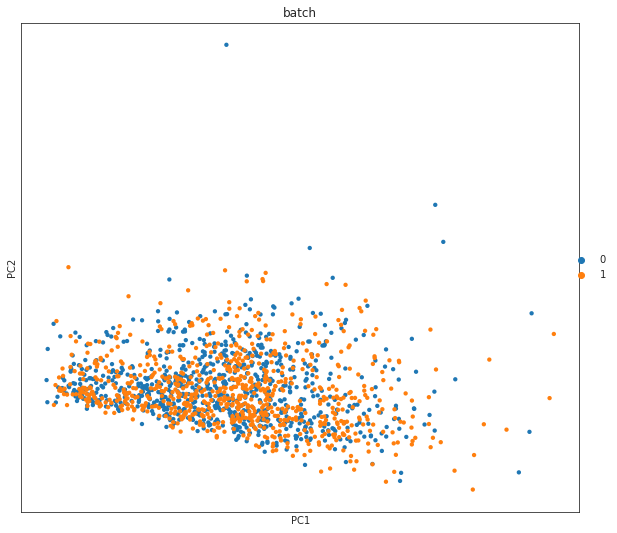

0.84437499999999999

In [21]:
score_batch_corr([CAOV3_B1, CAOV3_B2], N_NEIGHBORS)

# Add Random Gaussian Noise To BOTH Batch in Olivier's Data

In [22]:
# Return the indices of the elements that are non-zero.
rows, cols = CAOV3_B1.X.nonzero()
count = 0
for x, y in zip(rows, cols):

    CAOV3_B1.X[x, y] += np.random.normal(loc=-50, scale=100)  # mean = -50
    count += 1
    if count%100000 == 0:
        print(float(count)/len(rows)*100)  # progress tracking

4.318938024966917
8.637876049933833
12.956814074900752
17.275752099867667
21.594690124834585
25.913628149801504
30.232566174768415
34.551504199735334
38.87044222470225
43.18938024966917
47.50831827463608
51.82725629960301
56.14619432456992
60.46513234953683
64.78407037450376
69.10300839947067
73.42194642443759
77.7408844494045
82.05982247437143
86.37876049933834
90.69769852430525
95.01663654927216
99.33557457423909


In [23]:
rows, cols = CAOV3_B2.X.nonzero()
count = 0
for x, y in zip(rows, cols):
    CAOV3_B2.X[x, y] += np.random.normal(loc=50, scale=100)   # mean = 50
    count += 1
    if count%100000 == 0:
        print(float(count)/len(rows)*100)

4.257527628161161
8.515055256322322
12.772582884483482
17.030110512644644
21.287638140805807
25.545165768966964
29.802693397128127
34.06022102528929
38.31774865345045
42.575276281611615
46.83280390977277
51.09033153793393
55.34785916609509
59.605386794256255
63.86291442241742
68.12044205057857
72.37796967873975
76.6354973069009
80.89302493506206
85.15055256322323
89.40808019138439
93.66560781954554
97.9231354477067


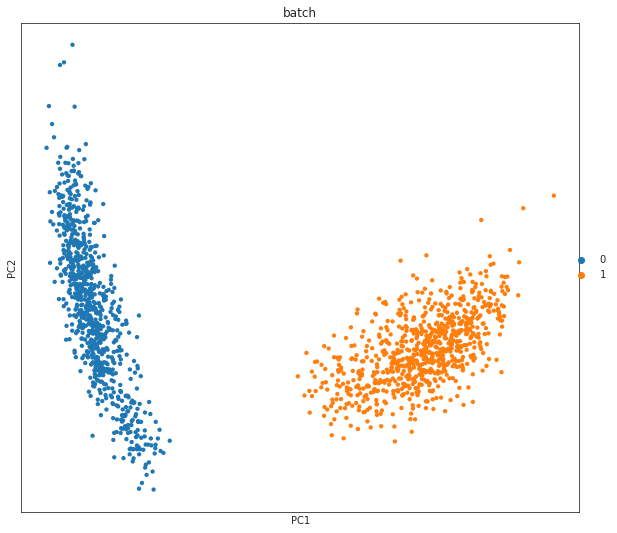

0.0

In [24]:
score_batch_corr([CAOV3_B1, CAOV3_B2], N_NEIGHBORS)

# Correct Data With Scanorama

Found 33694 genes among all datasets
[[ 0.    0.66]
 [ 0.    0.  ]]
Processing datasets (0, 1)


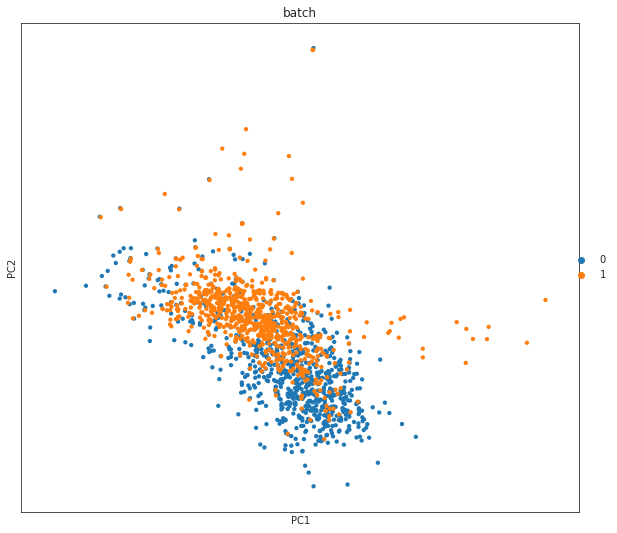

0.76424999999999998

In [25]:
CAOV3_B1_GAUSS_CORR, CAOV3_B2_GAUSS_CORR = scanorama.correct_scanpy([CAOV3_B1, CAOV3_B2])
score_batch_corr([CAOV3_B1_GAUSS_CORR, CAOV3_B2_GAUSS_CORR], N_NEIGHBORS)